In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.optimize import curve_fit

chart_dpi = 200

def get_tick(price):
    return np.log(price)/np.log(1.0001)


In [2]:
def usd_to_tokens(lower, upper, current, usd_investment):
    relation = (np.sqrt(current) - np.sqrt(lower))/ ((1/np.sqrt(current) - (1/np.sqrt(upper))))
    token0_amt = usd_investment / (current + relation*1)
    token1_amt = token0_amt * relation
    if token0_amt < 0 :
        token1_amt = token0_amt*current + token1_amt
        token0_amt = 0
    elif token1_amt < 0:
        token0_amt = token0_amt + token1_amt/current
        token1_amt = 0
    return (token0_amt, token1_amt)

class Position:
    def __init__(self,lower, upper, current, usd_investment, feeTier = 0.003):
        self.lower = lower
        self.upper = upper
        self.current = current
        self.usd_investment = usd_investment
        self.feeTier = feeTier

        tokens = usd_to_tokens(lower, upper, current, usd_investment)
        self.amt0 = tokens[0]
        self.amt1 = tokens[1]
        self.L = self.get_liquidity(current)
        
    def get_liquidity(self, current):
        if current <= self.lower:
            L = self.amt0 * (np.sqrt(self.upper)*np.sqrt(self.lower)/(np.sqrt(self.upper)-np.sqrt(self.lower)))
        elif self.lower < current <= self.upper:
            a = self.amt0* (np.sqrt(self.upper)*np.sqrt(current)/(np.sqrt(self.upper)-np.sqrt(current)))
            b = self.amt1/(np.sqrt(current) - np.sqrt(self.lower))
            L = min(a,b)
        else:
            L = self.amt1 / (np.sqrt(self.upper) - np.sqrt(self.lower))
        return L
    def get_current_tokens(self, current):
        L = self.L
        if current <= self.lower:
            amount0 = L / np.sqrt(self.lower) - L / np.sqrt(self.upper)
            amount1 = 0
        elif current < self.upper:
            amount0 = L / np.sqrt(current) - L/np.sqrt(self.upper)
            amount1 = L * np.sqrt(current) - L * np.sqrt(self.lower)
        else:
            amount1 = L* np.sqrt(self.upper) - L* np.sqrt(self.lower)
            amount0 = 0
        return (amount0, amount1)
    def get_current_value(self, current):
        tokens = self.get_current_tokens(current)
        return tokens[0] * current + tokens[1]

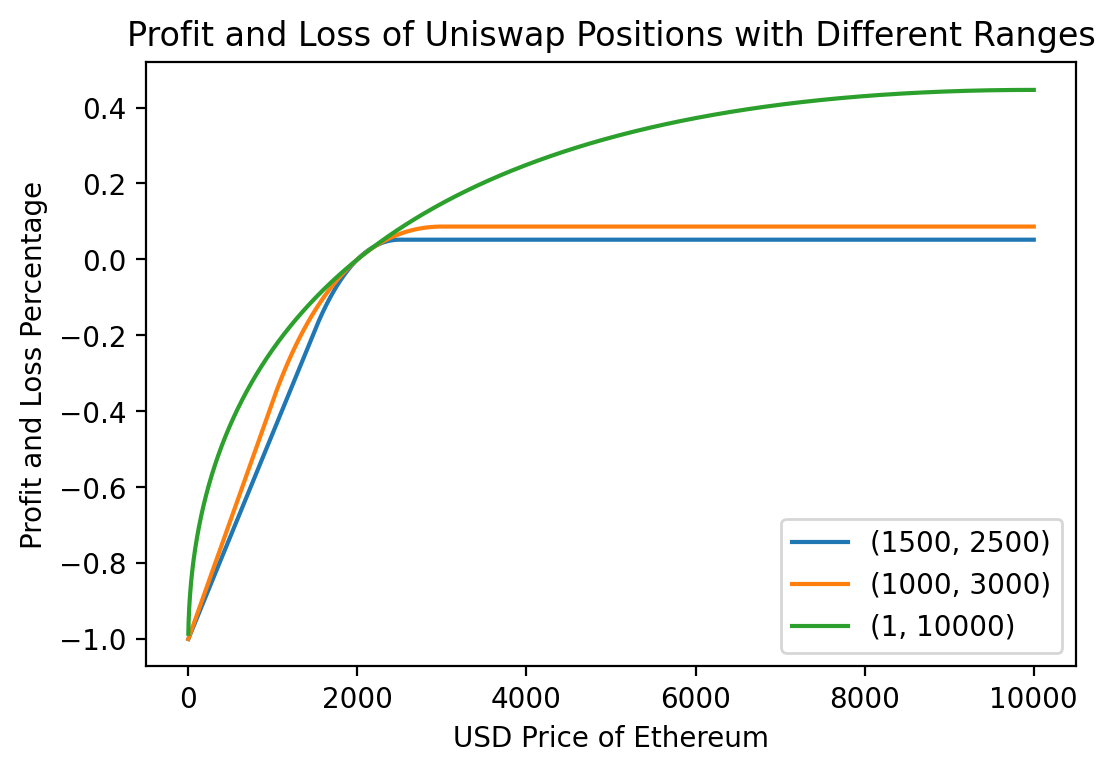

In [3]:
#function of impermenant loss. 
def IL(k, p, pa, pb):
    # if p < pa:
    #     p = pa
    if pa/p <= k <= pb/p:
        numer = 2*np.sqrt(k) - k - 1
        denom = (1-np.sqrt(p/pb))*k + (1- np.sqrt(pa/p))
    elif k < pa/p:
        numer = (np.sqrt(p/pa)-1)*k - (1-np.sqrt(pa/p))
        denom = (1-np.sqrt(p/pb))*k + (1-np.sqrt(pa/p))
    else:
        numer = np.sqrt(pb/p)-((1-np.sqrt(p/pb))*k) - 1
        denom = (1-np.sqrt(p/pb))*k + (1-np.sqrt(pa/p))
 
    return numer/denom

p1 = Position(1500, 2500, 2000, 10000)
p2 = Position(1000, 3000, 2000, 10000)
p3 = Position(1, 10000, 2000, 10000)
IL_vectorized = np.vectorize(IL)
# x = np.linspace(0, 5, 1000)
x = np.linspace(1, 10000, 10000)
# y= IL_vectorized(x, 2000, 1500, 2500)
# y2= IL_vectorized(x, 2000, 1000, 3000)
# y3= IL_vectorized(x, 2000, 0, 10000)
y = [p1.get_current_value(i)/10000- 1 for i in x]
y2 = [p2.get_current_value(i)/10000 - 1 for i in x]
y3 = [p3.get_current_value(i)/10000 -1 for i in x]
plt.figure(dpi=chart_dpi)
plt.plot(x,y, label='(1500, 2500)')
plt.plot(x,y2, label='(1000, 3000)')
plt.plot(x,y3, label='(1, 10000)')
plt.xlabel("USD Price of Ethereum")
plt.ylabel('Profit and Loss Percentage')
plt.title("Profit and Loss of Uniswap Positions with Different Ranges")
plt.legend()
plt.show()


p' = kp. So k here represents the percentage change in the price. the impermenant loss is measured as the value of a position on uniswap v3 versus the value of holding the same dollars worth of usd and cryptocurrency. For the ethereum example, it equals to holding 2000 dollars and 2000 dollars worth of ethereum at the currenct price. 

Impermanent loss is an imperfect measure of the performance of a uniswap position. This is because impermanent loss is the percetange loss of the portfolio compared to another portfolio that holds 50% ethereum and 50% cash. We need to convert impermanent loss to the strict dollar value of the uniswap position to better compare its performance to other types of portfolios relative to the price of ethereum. This can easily be done by multiplying the 50/50 portfolio by (1- impermanenet loss). This outputs the current dollar value of the portfolio. 

In [4]:
def only_usd(p, total):
    return total

def half_eth_half_usd(p, purchase_eth_price):
    return purchase_eth_price + p
def all_eth(p, purchase_eth_price, total):
    return (total/purchase_eth_price)*p

#dollar price of uniswap liquidity position
def uniswap_provision(p, purchase_eth_price, priceLower, priceUpper):
    if p > priceUpper:
        p = priceUpper
    current_value = purchase_eth_price + p
    k = p/purchase_eth_price
    return current_value*(1 + IL_vectorized(k, purchase_eth_price, priceLower, priceUpper))


in this example, the imperment loss of two positions can be combined using a weighted average. assuming the two positions have the same value, the impermenant loss will become the average the two the positions. from the graph, it can be seen that the impermanent loss is overall less for the prices on the two ends. the impermanentn loss near the balance price of the positions is more than the individual positions. the losses here will be offset by fees earned from providing liquidity. effectively, by combining two positions with different price ranges, you can design your impermanent loss to match what you expect will happen to the price of the underlying asset.

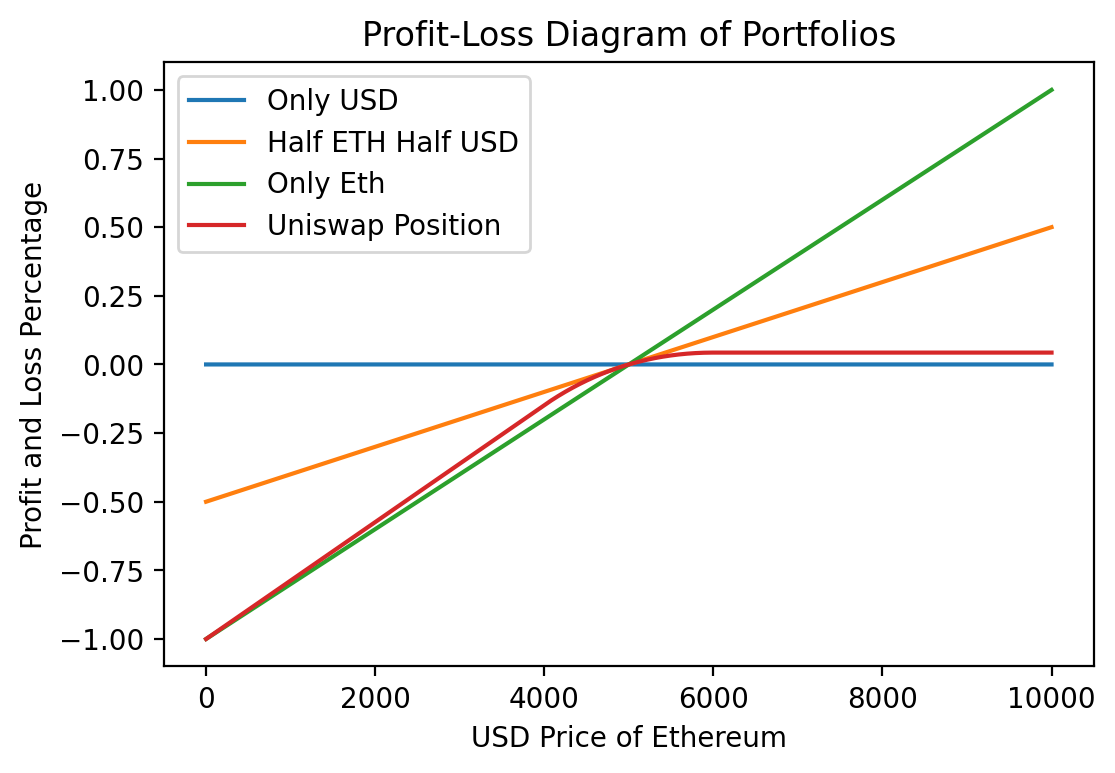

In [5]:
# portfolio comparison
x = np.linspace(0, 10000, 10000)
# y = [only_usd(i, 10000) for i in x]
# y2 = [half_eth_half_usd(i, 5000) for i in x]
# y3 = [all_eth(i, 5000, 10000) for i in x]
y = [only_usd(i, 10000)/10000 - 1 for i in x]
y2 = [half_eth_half_usd(i, 5000)/10000 - 1 for i in x]
y3 = [all_eth(i, 5000, 10000)/10000 - 1 for i in x]

p = Position(4000, 6000, 5000, 10000)
# y4 = [uniswap_provision(i, 5000, 4000, 6000) for i in x]
y4 = [p.get_current_value(i)/10000 - 1 for i in x]

plt.figure(dpi=chart_dpi)

plt.plot(x, y, label="Only USD")
plt.plot(x, y2, label="Half ETH Half USD")
plt.plot(x, y3, label = "Only Eth")
plt.plot(x, y4, label = "Uniswap Position")
plt.title("Profit-Loss Diagram of Portfolios")
plt.xlabel("USD Price of Ethereum")
plt.ylabel("Profit and Loss Percentage")
plt.legend()
plt.show()

In this example, a few portfolios and their dollar value is compared as the price of ethereum changes. The first portfolio is $10000 cash only. The second portfolio is half in ethereum and half in us dollars, the price of ethereum at the time bought is $5000. So there is $5000 in cash and one ethereum worth $5000. The third portfolio is only ethereum,the price of ethereum bought is $5000 so there are two units of ethereum total worth $10000.The last portfolio is the value of a uniswap position without fees. 

The cash only portfolio is least affected by price of ethereum as the value does not change. The 50/50 portfolio produces upside returns and downside losses as the price of ethereum changes. The ethereum only portfolio produces the biggest gains but also the biggest losses depending on the price of ethereum. The uniswap provision portfolio has similar returns as the only eth portfolio when the price is below $5000, and a relatively flat return when the price is above $5000. 

The uniswap liquidity position portfolio has returns that looks very much like a put option. However, there are a few differences. One difference is that the uniswap position does not have an expiration date, so losses will never be realized unless the funds in the uniswap position is withdrew from the platform. The second difference is that this returns chart does not take fees earned by the uniswap position into consideration. The trading fees earned by the uniswap position is what draws people to lock up their funds and become exposed to high risks. 

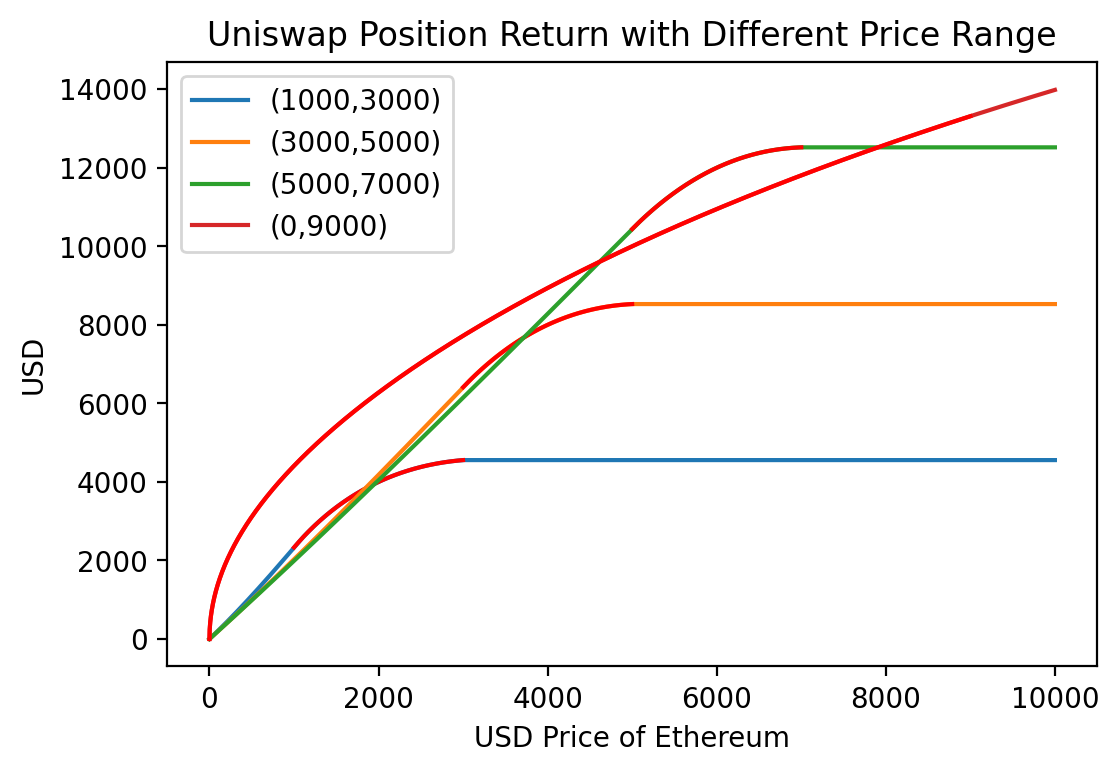

In [6]:
#returns of uniswap position with different price range
x = np.linspace(0, 10000, 10000)
y= np.array([uniswap_provision(i, 4000, 3000, 5000) for i in x])
y2= np.array([uniswap_provision(i, 2000,1000,3000) for i in x])
y3= np.array([uniswap_provision(i, 6000,5000,7000) for i in x])

y4= np.array([uniswap_provision(i,5000,0, 90000) for i in x])
plt.figure(dpi=chart_dpi)

plt.plot(x,y2, label="(1000,3000)")
plt.plot(x[1000:3000],y2[1000:3000], color="red")

plt.plot(x,y, label="(3000,5000)")
plt.plot(x[3000:5000],y[3000:5000], color="red")

plt.plot(x,y3,label="(5000,7000)")
plt.plot(x[5000:7000],y3[5000:7000], color="red")

plt.plot(x,y4,label="(0,9000)")
plt.plot(x[:9000],y4[:9000], color="red")
plt.legend()
plt.title("Uniswap Position Return with Different Price Range")
plt.xlabel("USD Price of Ethereum")
plt.ylabel("USD")
plt.show()

In this example, uniswap position with different price ranges are compared. The red portion of the line segment is when trading fees will be generated if the price of ethereum is within the range. We can observe that once the price of ethereum moves above the upper price range of the uniswap position, the value of the uniswap position grows much slower as the price of ethereum increase. When the price of ethereum is below the lower price range of the uniswap position, the value of the uniswap position grows linearly with as the price of ethereum increase. The position with price range (0,9000) appears to be better than the rest of the position with smaller ranges with the value being less affected by the change in the price of ethereum. This would be case if there were no trading fees. With trading fees, we would need to run monte carlo simulations to estimate which position is better. The position with the larger range will earn less trading fees because it has liquidity spread over a wider price range, this however reduces the risk of the price moving outside of the range resulting in no fees being earned. The position with smaller ranges will earn more trading fees because the liquidity is more concentrated. This however, increases the risk of the price moving outside of the range resulting in no fees being earned. 

Use in the money and out of the money for when price is in range or out of range. 

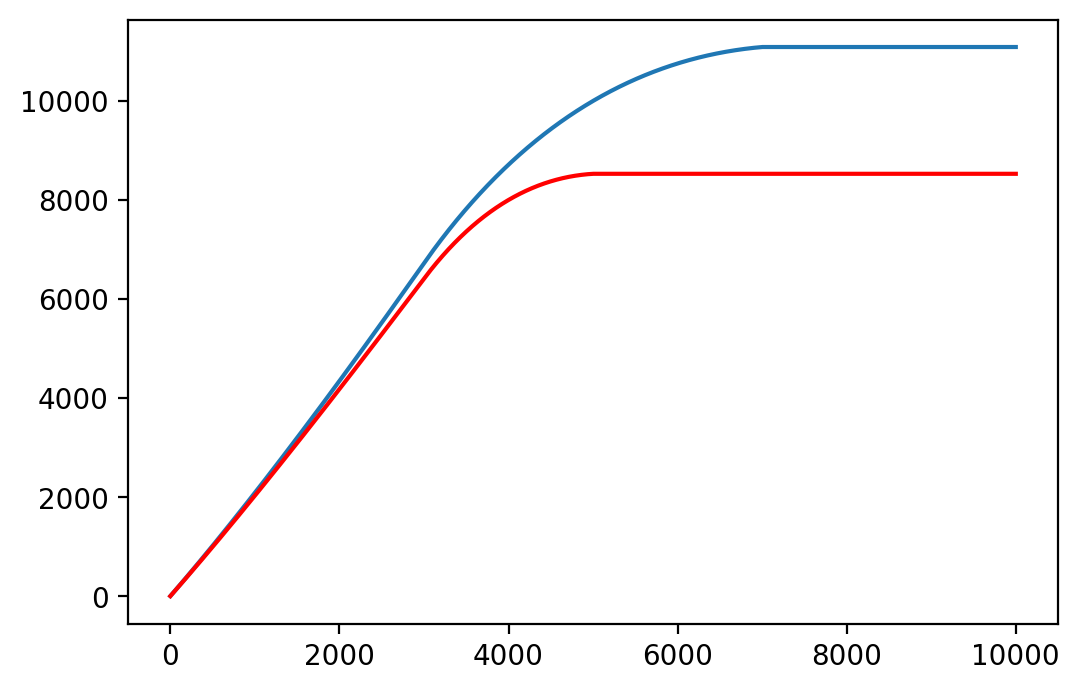

In [7]:
x = np.linspace(0, 10000, 10000)
y= np.array([uniswap_provision(i, 4000, 3000, 5000) for i in x])
y2= np.array([uniswap_provision(i, 6000,5000,7000) for i in x])
y3= np.array([uniswap_provision(i, 5000,3000,7000) for i in x])

# plt.plot(x, y)
# plt.plot(x,y2)
plt.figure(dpi=chart_dpi)

plt.plot(x,y3)
plt.plot(x, y, color="red")

plt.show()

In [8]:
#create a function of volume to volatility. approximation for volatility is sqrt(high - low)
#usdc eth 0.003 = "0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8"
#usdc eth 0.0005 = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
poolDayData = pd.read_csv("poolDayData.csv").sort_values(by="date", ascending = True)
poolHourData = pd.read_csv("poolHourData.csv").sort_values(by="periodStartUnix", ascending = True)

eth1PoolDayData = poolDayData[poolDayData['pool.id']=="0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8"]
eth1PoolHourData = poolHourData[poolHourData['pool.id']=="0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8"]

prices_day = eth1PoolDayData.iloc[:-1][['open', 'close']]
prices_day = (prices_day['open'] + prices_day['close'])/2
prices_day = [p for p in prices_day]
# print(eth1PoolDayData.iloc[:5][['date', 'open', 'close', 'low', 'high']])

# print(eth1PoolHourData.iloc[:][['periodStartUnix', 'open', 'close', 'low', 'high']])


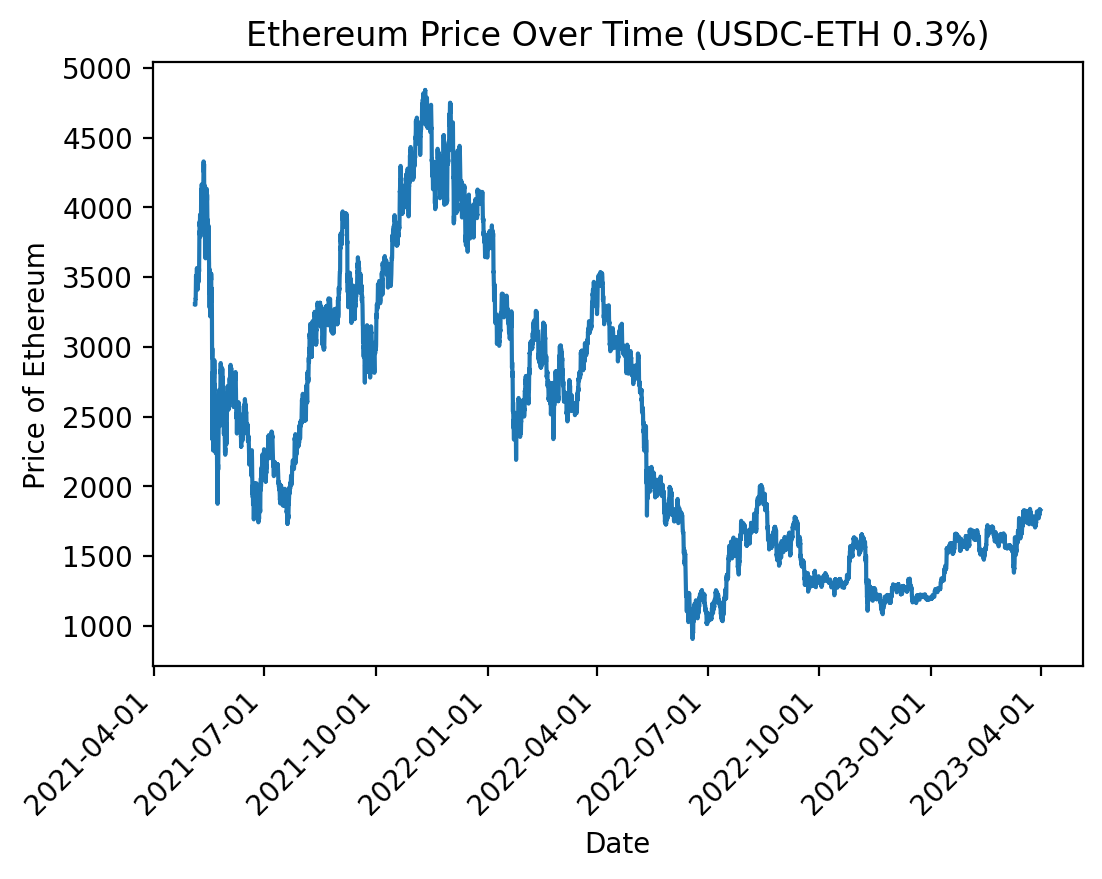

In [9]:
import matplotlib.dates as mdates
from datetime import datetime

timestamp_hour = eth1PoolHourData.iloc[1:]['periodStartUnix']
dates_hour = [datetime.fromtimestamp(ts) for ts in timestamp_hour]

timestamp_day = eth1PoolDayData.iloc[1:]['date']
dates_day = [datetime.fromtimestamp(ts) for ts in timestamp_day]

prices_hour = eth1PoolHourData.iloc[1:][['open', 'close']]
prices_hour = (prices_hour['open'] + prices_hour['close'])/2
prices_hour = [p for p in prices_hour]

fig, ax = plt.subplots(dpi=chart_dpi)

ax.plot(dates_hour, prices_hour)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Price of Ethereum')
plt.title('Ethereum Price Over Time (USDC-ETH 0.3%)')
plt.show()

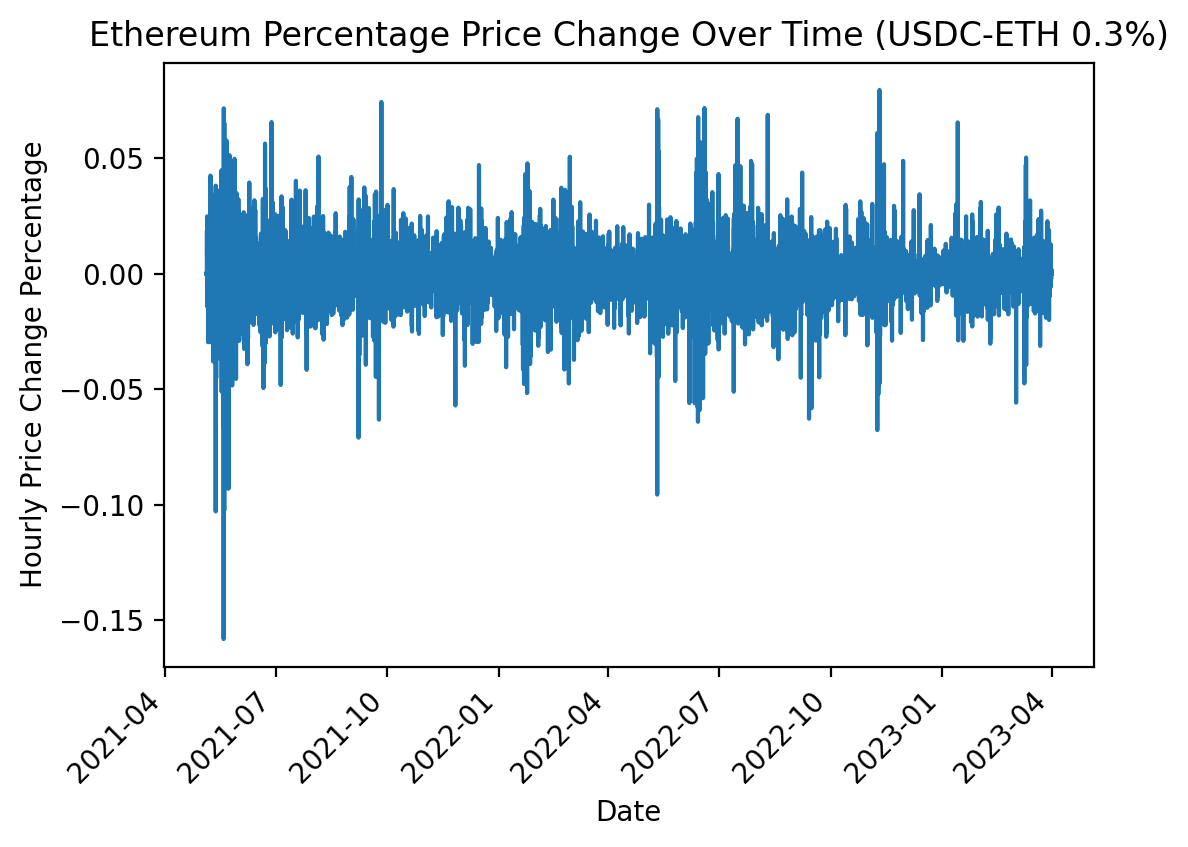

In [10]:
hour_price_change = eth1PoolHourData.iloc[1:][['open', 'close']]
hour_price_change = (hour_price_change['close'] - hour_price_change['open'])/hour_price_change['open']

fig, ax = plt.subplots(dpi=chart_dpi)
ax.plot(dates_hour, hour_price_change)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)

plt.xticks(rotation=45, ha='right')

plt.xlabel('Date')
plt.ylabel('Hourly Price Change Percentage')
plt.title('Ethereum Percentage Price Change Over Time (USDC-ETH 0.3%)')

# Show the plot
plt.show()

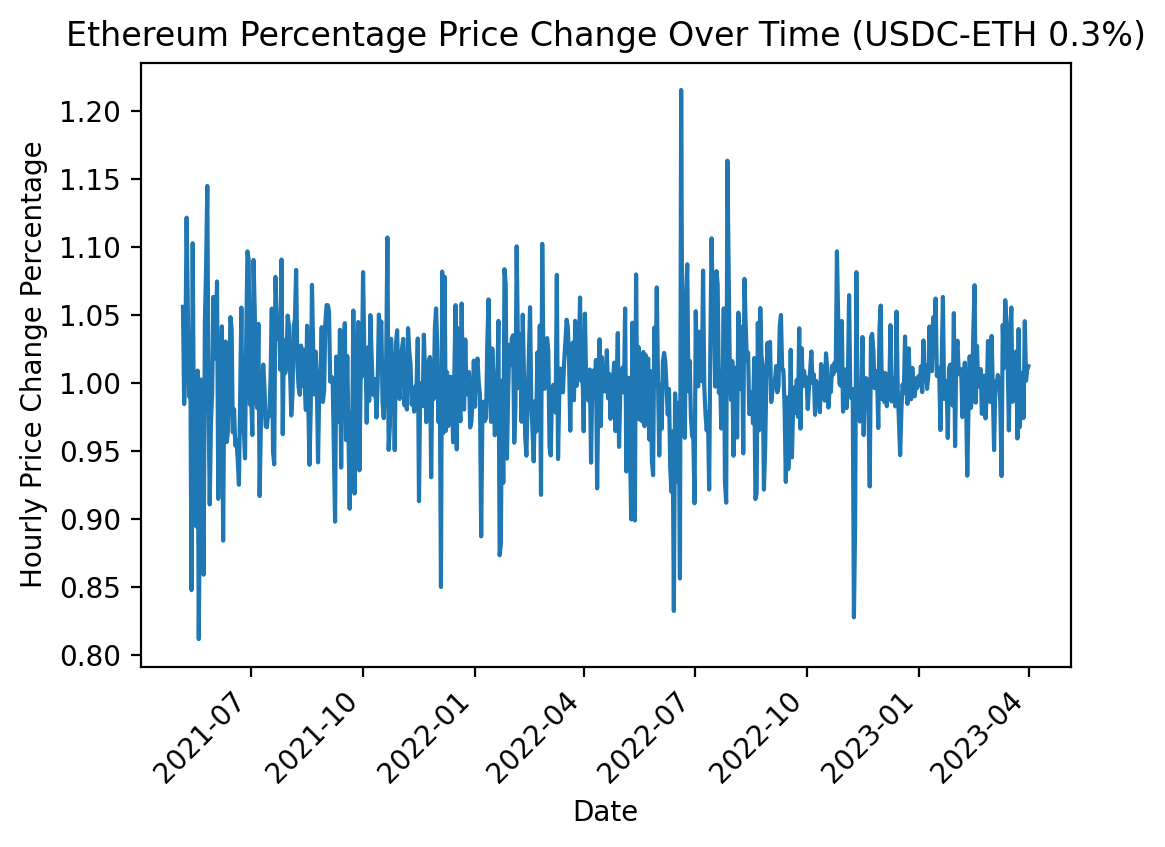

In [11]:
# price_change_day = eth1PoolDayData.iloc[:-1][['open', 'close']]
x_price_change_day = []
price_change_day =[]
chunk_size = 24
for i in range(0, len(hour_price_change), chunk_size):
    chunk = np.array(hour_price_change[i:i+chunk_size]) + 1
    x_price_change_day.append(dates_hour[min(i+chunk_size, len(dates_hour)-1)]) 
    price_change_day.append(np.cumprod(chunk)[-1])

# price_change_day = (price_change_day['close'] - price_change_day['open'])/price_change_day['open']

fig, ax = plt.subplots(dpi=chart_dpi)
ax.plot(x_price_change_day, price_change_day)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)

plt.xticks(rotation=45, ha='right')

plt.xlabel('Date')
plt.ylabel('Hourly Price Change Percentage')
plt.title('Ethereum Percentage Price Change Over Time (USDC-ETH 0.3%)')

plt.show()

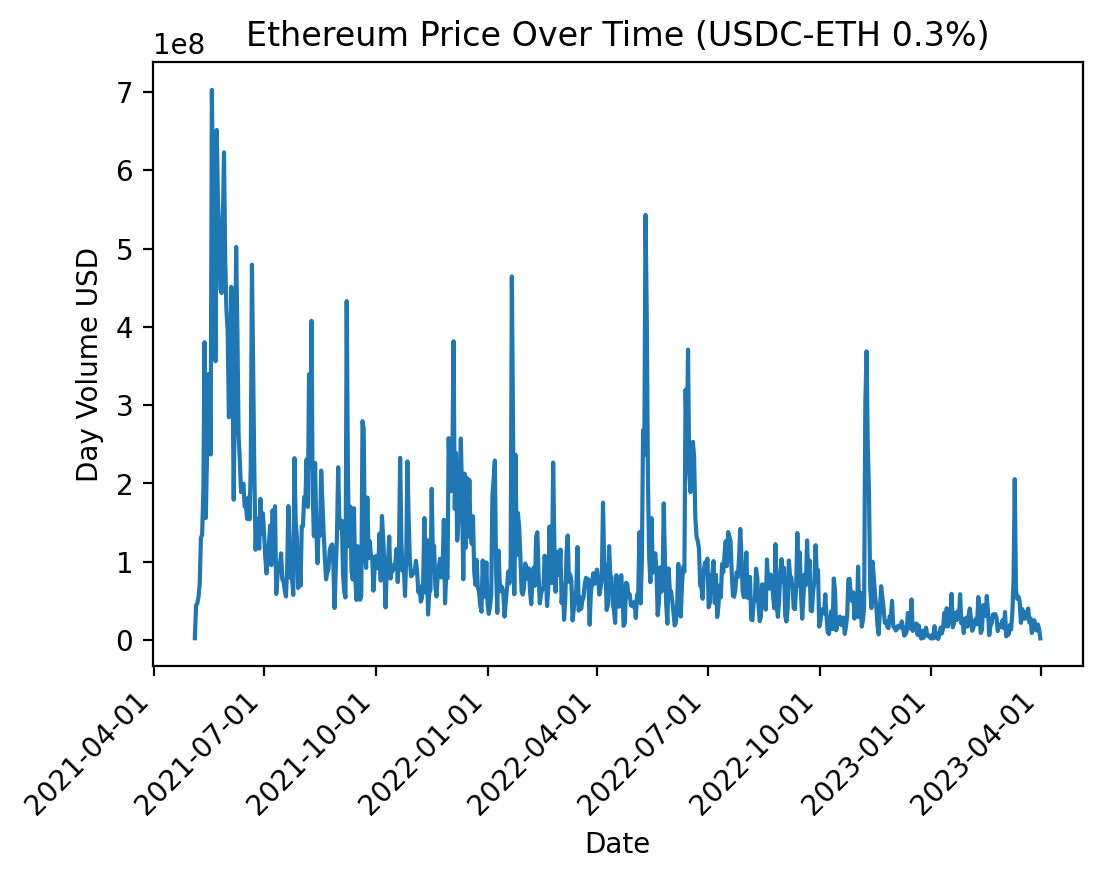

In [12]:
# import seaborn as sns
# sns.set_theme()

volume_day = eth1PoolDayData.iloc[1:]['volumeUSD']

fig, ax = plt.subplots(dpi=chart_dpi)
ax.plot(dates_day, volume_day)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)

plt.xticks(rotation=45, ha='right')

plt.xlabel('Date')
plt.ylabel('Day Volume USD')
plt.title('Ethereum Price Over Time (USDC-ETH 0.3%)')

# Show the plot
plt.show()

[[1.        0.4344527]
 [0.4344527 1.       ]]


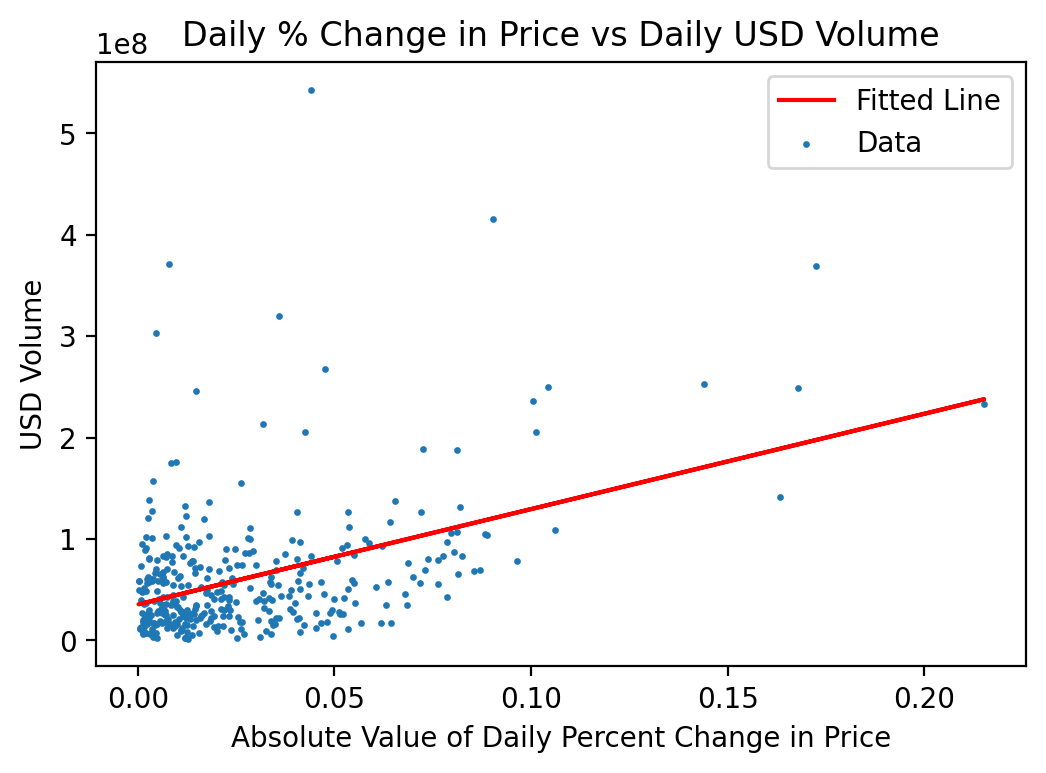

[9.40484676e+08 3.54006653e+07]


In [13]:
#fit function volume = f(sqrt(high-low))
def linear_function(x, a, b):
    return a * x + b
x_data = np.array(price_change_day)
x_data = np.array([np.abs(x - 1) for x in x_data])
y_data = np.array(volume_day[2:])
x_data = x_data[-365:]
y_data = y_data[-365:]
params, cov = curve_fit(linear_function, x_data, y_data)
a_fit, b_fit = params
print(np.corrcoef(x_data, y_data))
plt.figure(dpi=chart_dpi)
plt.scatter(x_data, y_data, s = 2, label="Data")
plt.plot(x_data, linear_function(x_data, a_fit, b_fit), color = "red", label = "Fitted Line")
plt.xlabel("Absolute Value of Daily Percent Change in Price")
plt.ylabel("USD Volume")
plt.title("Daily % Change in Price vs Daily USD Volume")
plt.legend()
plt.show()
print(params)


In [14]:
# def usd_to_tokens(lower, upper, current, usd_investment):
#     relation = (np.sqrt(current) - np.sqrt(lower))/ ((1/np.sqrt(current) - (1/np.sqrt(upper))))
#     token0_amt = usd_investment / (current + relation*1)
#     token1_amt = token0_amt * relation
#     if token0_amt < 0 :
#         token1_amt = token0_amt*current + token1_amt
#         token0_amt = 0
#     elif token1_amt < 0:
#         token0_amt = token0_amt + token1_amt/current
#         token1_amt = 0
#     return (token0_amt, token1_amt)

# class Position:
#     def __init__(self,lower, upper, current, usd_investment, feeTier):
#         self.lower = lower
#         self.upper = upper
#         self.current = current
#         self.usd_investment = usd_investment
#         self.feeTier = feeTier

#         tokens = usd_to_tokens(lower, upper, current, usd_investment)
#         self.amt0 = tokens[0]
#         self.amt1 = tokens[1]
#         self.L = self.get_liquidity(current)
        
#     def get_liquidity(self, current):
#         if current <= self.lower:
#             L = self.amt0 * (np.sqrt(self.upper)*np.sqrt(self.lower)/(np.sqrt(self.upper)-np.sqrt(self.lower)))
#         elif self.lower < current <= self.upper:
#             a = self.amt0* (np.sqrt(self.upper)*np.sqrt(current)/(np.sqrt(self.upper)-np.sqrt(current)))
#             b = self.amt1/(np.sqrt(current) - np.sqrt(self.lower))
#             L = min(a,b)
#         else:
#             L = self.amt1 / (np.sqrt(self.upper) - np.sqrt(self.lower))
#         return L
#     def get_current_tokens(self, current):
#         L = self.L
#         if current <= self.lower:
#             amount0 = L / np.sqrt(self.lower) - L / np.sqrt(self.upper)
#             amount1 = 0
#         elif current < self.upper:
#             amount0 = L / np.sqrt(current) - L/np.sqrt(self.upper)
#             amount1 = L * np.sqrt(current) - L * np.sqrt(self.lower)
#         else:
#             amount1 = L* np.sqrt(self.upper) - L* np.sqrt(self.lower)
#             amount0 = 0
#         return (amount0, amount1)
#     def get_current_value(self, current):
#         tokens = self.get_current_tokens(current)
#         return tokens[0] * current + tokens[1]
p = Position(2000, 4000,3000, 10000, 0.0003)
print(p.get_current_value(6000))
print(p.L)

print(p.L/Position(100, 6000,3000, 1.15e+8, 0.0003).L)

10652.830784043406
575.076625918579
0.0003041139117649503


In [15]:

def price_movement_to_trading_range(price_movement):
    price_returns = (price_movement[1:] - price_movement[:-1]) / price_movement[:-1]
    return np.array([np.abs(x) for x in price_returns])

def trading_range_to_volume(trading_range):
    return linear_function(trading_range, a_fit, b_fit)

def calculate_fee(price_movement, position, total_pool_liquidity):
    mask = (price_movement > position.lower) & (price_movement < position.upper)
    coverage = np.sum(mask)/len(price_movement)
    trading_range = price_movement_to_trading_range(price_movement)
    volume = trading_range_to_volume(trading_range)
    fee = 0
    for i in range(len(volume)):
        value = position.get_current_value(price_movement[i+1])
        if position.lower < price_movement[i+1] < position.upper:
            # fee += value/total * volume[i] * position.feeTier * position.L/total_pool_liquidity
            fee +=  volume[i] * position.feeTier * position.L/total_pool_liquidity

    return fee


In [16]:
#volatility calculation
past_year_daily_prices = prices_day[-365:]
# past_year_daily_prices.reverse()
past_year_daily_prices = np.array(past_year_daily_prices)
past_year_daily_returns = (past_year_daily_prices[1:] - past_year_daily_prices[:-1]) / past_year_daily_prices[:-1]

daily_vol = np.std(past_year_daily_returns)
annual_vol = np.sqrt(252)* daily_vol

print(daily_vol)
print(annual_vol)

0.04359539821712845
0.692055491936103


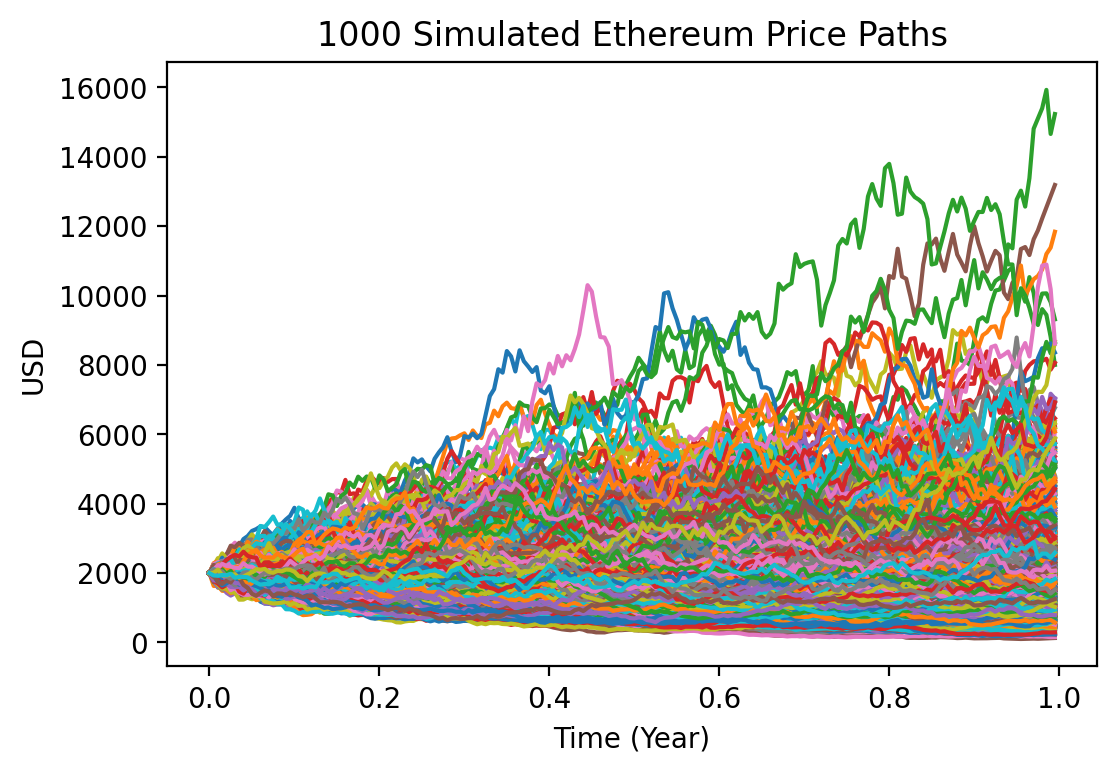

In [66]:
#stochastic differential equation of uniswap v3 position
mu = 0
sigma = annual_vol
T = 1.0
dt = 0.005
N = int(T/dt)
n_simulations = 1000

time_array = np.arange(0, T, dt)
S = np.zeros((n_simulations, N))
initial_price = 2000
S[:, 0] = initial_price

for t in range(1, N):
    dW = np.sqrt(dt) * np.random.normal(0,1, n_simulations)
    dS = mu*dt + sigma*dW
    S[:,t] = S[:, t-1] *(1 + dS)
plt.figure(dpi=chart_dpi)
plt.title("1000 Simulated Ethereum Price Paths")
plt.xlabel("Time (Year)")
plt.ylabel("USD")
for i in range(n_simulations):
    plt.plot(time_array, S[i])

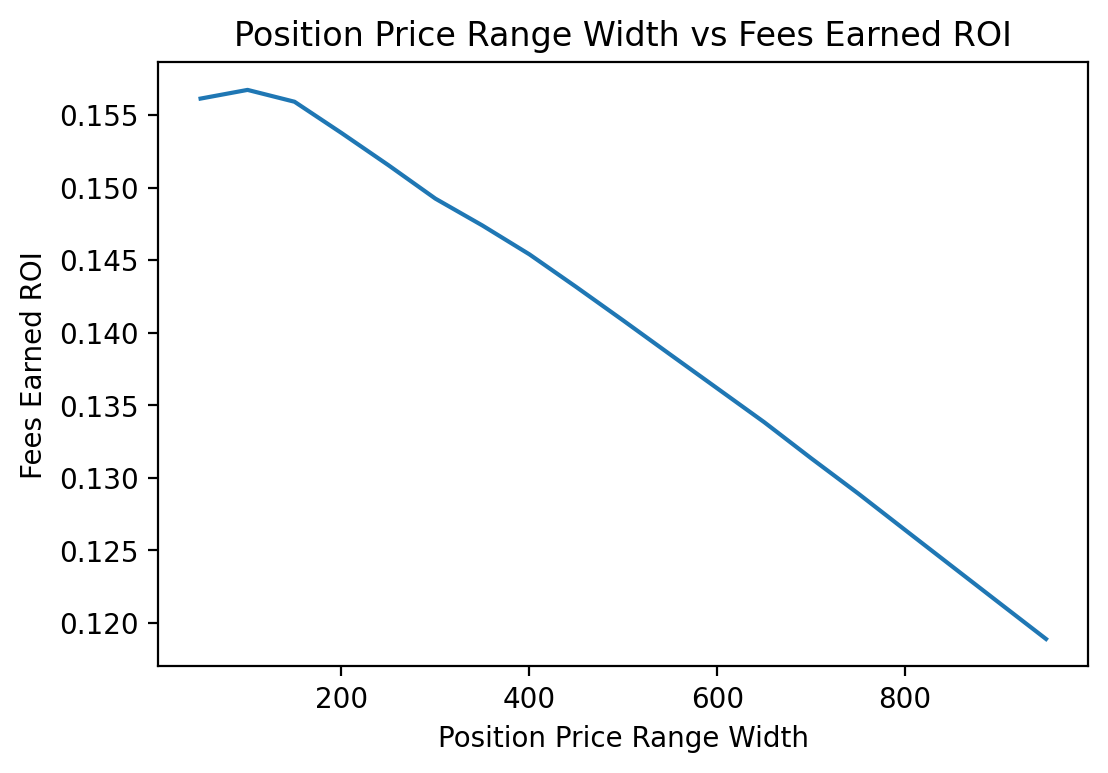

In [93]:
#expected value of fees earned over different price ranges
range_width = [i for i in range(50, 1000, 50)]
total_pool_liquidity = Position(100, 5000,3000, 0.75e+8, 0.0003).L
fees_per_range_width = []
inital_investment = 1e+4
for r in range_width:
    p = Position(initial_price-r, initial_price+r, initial_price, inital_investment, 0.0003)
    fees_per_range_width.append(np.mean([calculate_fee(si, p, total_pool_liquidity) for si in S])/inital_investment)
plt.figure(dpi=chart_dpi)
plt.xlabel("Position Price Range Width")
plt.ylabel("Fees Earned ROI")
plt.title("Position Price Range Width vs Fees Earned ROI")
plt.plot(range_width, fees_per_range_width)

Fees generated decreases as the range width increase. However, smaller range has more impermanent loss. More fees are generated when the price range is smaller because the same liquidity is spread into a smaller price range resulting in more liquidity at each price tick. When more liquidity is at each tick, more fees will be generated.

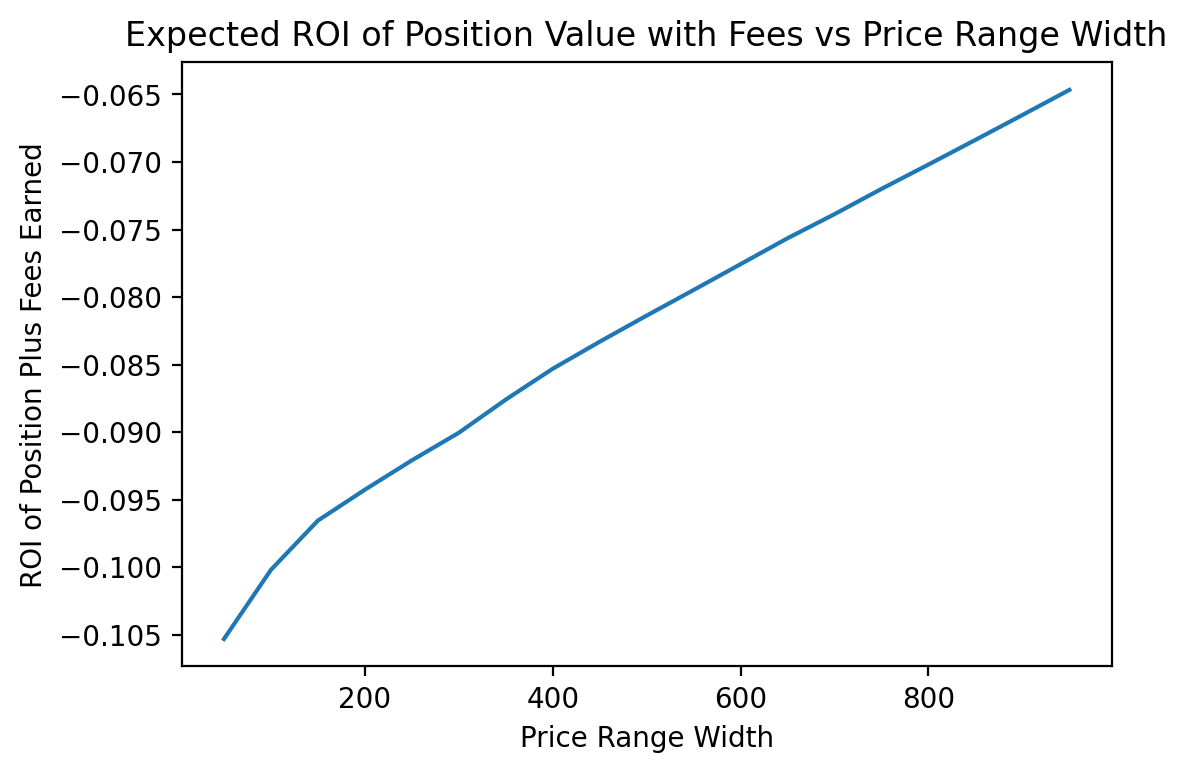

In [106]:
range_width = [i for i in range(50, 1000, 50)]
expected_value_per_range_width = []
total_pool_liquidity = Position(100, 5000,3000, 0.75e+8, 0.0003).L
for r in range_width:
    initial_investment = 1e+4
    p = Position(initial_price-r, initial_price+r, initial_price, initial_investment, 0.0003)
    expected_fees = np.mean([calculate_fee(si, p,total_pool_liquidity) for si in S])
    expected_value = np.mean([p.get_current_value(si[-1]) for si in S])
    expected_value_per_range_width.append((expected_value + expected_fees)/initial_investment -1)
plt.figure(dpi=chart_dpi)
plt.title("Expected ROI of Position Value with Fees vs Price Range Width")
plt.xlabel("Price Range Width")
plt.ylabel("ROI of Position Plus Fees Earned")
plt.plot(range_width, expected_value_per_range_width)

The larger the price range, the value of the uniswap position with fees increases in expectation. The return on invest is negative because it depends on the fees generated. The amount of trading fees earned by uniswap is relatively stable. So if more liquidity or capital is put into the Uniswap pools, then the ROI will decrease because the same amount of fees is being earned a larger investment base.  

In [107]:
from scipy.stats import norm
initial_investment = 1e+4
total_pool_liquidity = Position(100, 5000,3000, 0.5e+8, 0.0003).L
p = Position(initial_price-500, initial_price+500, initial_price, initial_investment, 0.0003)
fees = np.array([calculate_fee(si, p,total_pool_liquidity) for si in S])
pos_value = np.array([p.get_current_value(si[-1]) for si in S])
total = fees + pos_value
# Position with 1500 - 2500 price range with price at 2000.
returns = (total - initial_investment)/initial_investment
print("Expected Return: ", np.mean(returns))
print("Standard deviation: ", np.std(returns))

# 95% confidence value at risk
time_horizon = 1
confidence_level = 0.95
z_score = -1 * np.percentile(returns, 100 * (1 - confidence_level))
VaR = initial_investment * (z_score * np.sqrt(time_horizon))

ES = np.mean([(initial_investment - x) for x in total if x < (initial_investment - VaR)])
break_even_probability = 1 - norm.cdf(0, np.mean(returns), np.std(returns))
print("Break Even Probability: ", break_even_probability)
print("Value at Risk: ", VaR/inital_investment)
print("Expected Shortfall: ", ES/inital_investment)

Expected Return:  -0.010948239607838837
Standard deviation:  0.342708815990045
Break Even Probability:  0.4872574831254829
Value at Risk:  0.6306493466508535
Expected Shortfall:  0.7191741689880561


In [108]:
initial_investment = 1e+4
p = Position(initial_price-1500, initial_price+1500, initial_price, initial_investment, 0.0003)
fees = np.array([calculate_fee(si, p,total_pool_liquidity) for si in S])
pos_value = np.array([p.get_current_value(si[-1]) for si in S])
total = fees + pos_value
# Position with 1500 - 2500 price range with price at 2000.
returns = (total - initial_investment)/initial_investment
print("Expected Return: ", np.mean(returns))
print("Standard deviation: ", np.std(returns))

# 95% confidence value at risk
time_horizon = 1
confidence_level = 0.95
z_score = -1 * np.percentile(returns, 100 * (1 - confidence_level))
VaR = initial_investment * (z_score * np.sqrt(time_horizon))
ES = np.mean([(initial_investment - x) for x in total if x < (initial_investment - VaR)])
break_even_probability = 1 - norm.cdf(0, np.mean(returns), np.std(returns))
print("Break Even Probability: ", break_even_probability)
print("Value at Risk: ", VaR/inital_investment)
print("Expected Shortfall: ", ES/inital_investment)

Expected Return:  -0.00025532507337891095
Standard deviation:  0.22644286593926644
Break Even Probability:  0.49955017374907595
Value at Risk:  0.45382400534226675
Expected Shortfall:  0.5811242440831134


<ipython-input-15-c2753a0f1d8d>:10: RuntimeWarning: invalid value encountered in long_scalars
  coverage = np.sum(mask)/len(price_movement)


6938.6922011671695 11842.942022038882


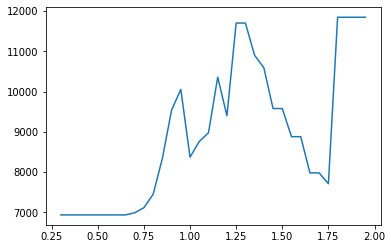

In [103]:
#Active portfolio

def position_value_with_rebalance(r, price_mov, investment_value, rebalance=False, mult = 1):
    r = 500
    previous_rebalance_index = 0
    price_mov = S[0]
    p = Position(initial_price - r, initial_price + r, initial_price, initial_investment, 0.0003)
    for i in range(len(price_mov)):
        if (price_mov[i] < (p.lower/mult) or price_mov[i] > (p.upper*mult)) and rebalance:
            fees = calculate_fee(price_mov[previous_rebalance_index:i], p,total_pool_liquidity)
            value = p.get_current_value(price_mov[i])
            investment_value = fees+value
            p = Position(max(price_mov[i] - r, 1), price_mov[i] + r, price_mov[i], investment_value, p.feeTier)
            previous_rebalance_index = i

    final_value = p.get_current_value(price_mov[-1])
    fees = 0
    if previous_rebalance_index < len(price_mov)-1:
        fees = calculate_fee(price_mov[previous_rebalance_index:len(price_mov)], p,total_pool_liquidity)
    return final_value + fees

investment_value = 10000
value_avg_rebalance = np.mean([position_value_with_rebalance(500, si, investment_value, True,0.5) for si in S])
value_avg_no_rebalance = np.mean([position_value_with_rebalance(500, si, investment_value, False) for si in S])
x_inputs = np.array(list(range(30, 200, 5)))


y_outputs = [np.mean([position_value_with_rebalance(500, si, investment_value, True,i/100) for si in S]) for i in x_inputs]
print(value_avg_rebalance, value_avg_no_rebalance)
plt.plot(x_inputs/100, y_outputs)


On expectation, actively balancing uniswap positions produces 